In [1]:
# ================================
# Imports
# ================================

import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
# ================================
# Load and preprocess Titanic dataset
# ================================

titanic = fetch_openml("titanic", version=1, as_frame=True)
df = titanic.frame

pd.set_option('display.max_columns', None)

df = df[["age", "sex", "pclass", "survived"]].dropna().copy()  #drops null values
df["sex"] = df["sex"].map({"male": 0, "female": 1}).astype(int)  #maps male --> 0 and female -->1
df["pclass"] = df["pclass"].astype(int)  #ensures pclass is int

x = df[["age", "sex", "pclass"]].to_numpy(dtype=float)  # (m,3)
y = df["survived"].astype(int).to_numpy()  # (m,1)

#split the dataset into test/train (80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

m, n = x_train.shape
print("x_train:", x_train.shape, "y_train:", y_train.shape)

mu = x_train.mean(axis=0)
sigma = x_train.std(axis=0) + 1e-12

x_train_s = (x_train - mu) / sigma
x_test_s = (x_test - mu) / sigma





x_train: (836, 3) y_train: (836,)


In [3]:
# ================================
# Model functions
# ================================

def sigmoid(z):
    z = np.clip(z, -500, 500)   # prevents exp overflow
    return 1.0 / (1.0 + np.exp(-z))

def predict_proba(w, b, X):
    # X: (m, n), w: (n,), b: scalar -> returns (m,)
    return sigmoid(X @ w + b)

def binary_cross_entropy(p, y):
    # p, y: (m,)
    p = np.clip(p, 1e-15, 1 - 1e-15)
    m = y.size
    return (-1/m) * np.sum(y*np.log(p) + (1-y)*np.log(1-p))

def predict_label(w, b, X, threshold=0.5):
    return (predict_proba(w, b, X) >= threshold).astype(int)

In [4]:
# ================================
# Initialize parameters
# ================================

w = np.zeros(x_train.shape[1])
b=0
a=0.01

costs = []

In [5]:
# ================================
# Training loop (Gradient Descent)
# ================================
def fit_logreg_gd(X, y, lr=0.1, num_iterations=10000, print_every=100, tol=1e-7):
    m, n = X.shape
    w = np.zeros(n, dtype=float)
    b = 0.0
    costs = []

    for i in range(num_iterations):
        # forward
        p = predict_proba(w, b, X)          # (m,)
        err = p - y                         # (m,)

        # gradients (already averaged)
        w_grad = (X.T @ err) / m            # (n,)
        b_grad = err.sum() / m              # scalar

        # update
        w -= lr * w_grad
        b -= lr * b_grad


        if i % print_every == 0:
            p_now = predict_proba(w, b, X)
            cost = binary_cross_entropy(p_now, y)
            costs.append(cost)
            print(f"iteration {i}, cost = {cost:.6f}")

            if len(costs) > 1 and abs(costs[-2] - costs[-1]) < tol:
                print(f"converged at iteration {i}")
                break

    return w, b, costs

In [6]:
# ================================
# Train
# ================================

w, b, costs = fit_logreg_gd(
    x_train_s, y_train,
    lr=0.1,
    num_iterations=10000,
    print_every=100,
    tol=1e-7
)

print("w:", w)
print("b:", b)

iteration 0, cost = 0.682049
iteration 100, cost = 0.462173
iteration 200, cost = 0.453174
iteration 300, cost = 0.451723
iteration 400, cost = 0.451402
iteration 500, cost = 0.451324
iteration 600, cost = 0.451305
iteration 700, cost = 0.451300
iteration 800, cost = 0.451299
iteration 900, cost = 0.451298
iteration 1000, cost = 0.451298
converged at iteration 1000
w: [-0.52528232  1.28625668 -0.97976307]
b: -0.5312969951052836


In [7]:
# ================================
# Evaluation
# ================================
y_pred_train = predict_label(w, b, x_train_s)
p_train = predict_proba(w, b, x_train_s)
train_cost = binary_cross_entropy(p_train, y_train)

y_pred_test  = predict_label(w, b, x_test_s)
p_test = predict_proba(w,b,x_test_s)
test_cost = binary_cross_entropy(p_test,y_test)

train_acc = (y_pred_train == y_train).mean()
test_acc  = (y_pred_test  == y_test ).mean()

print(f"Train accuracy: {train_acc:.4f}")
print(f"Train BCE: {train_cost:.4f}")
print(f"Test accuracy : {test_acc:.4f}")
print(f"Test BCE: {test_cost:.4f}")

Train accuracy: 0.8002
Train BCE: 0.4513
Test accuracy : 0.7381
Test BCE: 0.5468


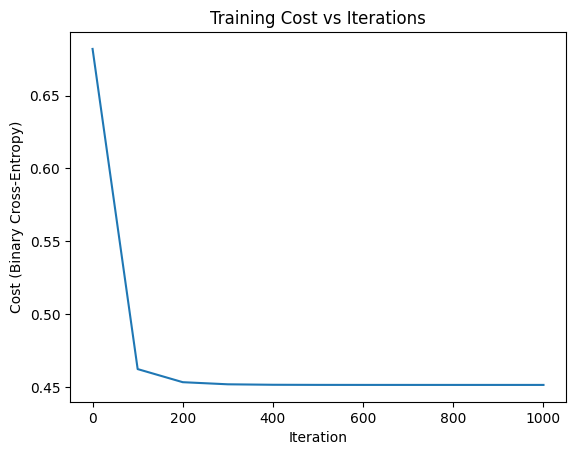

In [8]:
# ================================
# Cost Plot
# ================================
plt.plot(np.arange(len(costs)) * 100, costs)
plt.xlabel("Iteration")
plt.ylabel("Cost (Binary Cross-Entropy)")
plt.title("Training Cost vs Iterations")
plt.show()

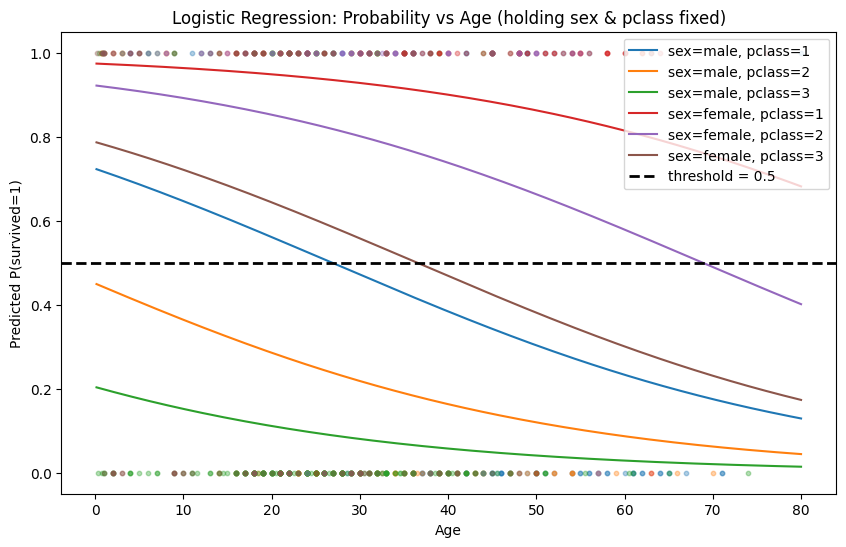

In [9]:
# ================================
# Visualization
# ================================
# Plot survival probability vs Age
age_vals = np.linspace(df["age"].min(), df["age"].max(), 200)

sex_values = [0, 1]      # 0=male, 1=female
pclass_values = [1, 2, 3]

sex_name = {0: "male", 1: "female"}

plt.figure(figsize=(10, 6))

for sex in sex_values:
    for pclass in pclass_values:
        X_curve = np.column_stack([
            age_vals,
            np.full_like(age_vals, sex),
            np.full_like(age_vals, pclass)
        ]).astype(float)

        # scale using train stats (from earlier)
        X_curve_s = (X_curve - mu) / sigma

        probs = predict_proba(w, b, X_curve_s)

        plt.plot(age_vals, probs, label=f"sex={sex_name[sex]}, pclass={pclass}")

        # scatter only points matching this subgroup
        mask = (x_train[:, 1] == sex) & (x_train[:, 2] == pclass)
        plt.scatter(x_train[mask, 0], y_train[mask], s=10, alpha=0.35)

# Decision threshold line at 0.5
plt.axhline(0.5,color= "black", linestyle="--", linewidth=2, label="threshold = 0.5")

plt.xlabel("Age")
plt.ylabel("Predicted P(survived=1)")
plt.title("Logistic Regression: Probability vs Age (holding sex & pclass fixed)")
plt.ylim(-0.05, 1.05)
plt.legend(loc = "upper right")
plt.show()